# CMSE 831 Final Project
### &#9989; Mahnoor Sheikh
#### &#9989; Nov 20, 2025

# ___Optimizing the Binary Classification Problem: Fake News Classification___

## Background and Motivation

The proliferation of fake news on critical topics remains a persistent problem on the web. False information is often used as a means to spread hysteria and panic among gullible readers who seldom fact-check. Manual verification itself is a cumbersome task requiring extensive research and critical evaluation, making it time-consuming and impractical for everyday readers.

To address this issue, I have developed a text classification pipeline based on the highly interpretable and effective model for linearly separable problems: Logistic Regression. Training logistic regression translates into a regularized convex optimization problem, where the objective function to be minimized is the negative log-likelihood with L2 regularization. This unconstrained optimization problem can vary dramatically in performance based on the different numerical optimization algorithms used. Hence, the questions I set out to answer are: *How do different optimization algorithms behave when applied to the same convex objective function for fake-news classification? Which optimization algorithm proves to be the most effective in terms of convergence speed, accuracy, and computational efficiency?*

This pushes my goal for the project beyond a trivial binary classification task. By implementing and comparing four major optimisers:
- Gradient descent with approximate line search,
- Non-linear Conjugate Gradient method (Fletcher–Reeves and Polak–Ribiere) with approximate line search,
- Newton method, and
- Quasi-Newton BFGS (L-BFGS) with approximate line search,

the project provides empirical insights into their convergence properties when minimizing a convex machine-learning loss function. Overall, this project will help make fact-checking time-efficient, transparent, and accessible.

## Methodology

In [49]:
## import libraries
import re
import os
import kagglehub
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
from collections import deque
import matplotlib.pyplot as plt
from scipy.optimize import line_search
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


I have employed the [WELFake Dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification), which is a combination of four popular news datasets (Kaggle, McIntire, Reuters, BuzzFeed Political). It contains a collection of news articles labeled as 'real' or 'fake'. The features include the title, text, and label, where '0' indicates fake news and '1' indicates real news. The dataset contains 72,134 samples and is fairly balanced, with 37,106 real news articles and 35,028 fake news articles.

In [ ]:
## import dataset
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
print("Path to dataset files:", path)
file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, file))
if "Unnamed: 0" in df.columns: # drop unnecessary index column
    df = df.drop(columns=["Unnamed: 0"])
print(df.shape)
print(df['label'].value_counts())
print(df.head())


Path to dataset files: C:\Users\manos\.cache\kagglehub\datasets\saurabhshahane\fake-news-classification\versions\77
(72134, 3)
label
1    37106
0    35028
Name: count, dtype: int64
                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


Data Cleaning and Preprocessing

In [ ]:
## clean dataset

# remove excessive whitespaces, line breaks
def remove_whitespaces(text):
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text) # multiple spaces into single space
    text = re.sub(r'\n{3,}', '\n\n', text) # 3+ consecutive newlines into two to keep paragraph breaks
    return text.strip() # drop leading/trailing whitespaces

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    # remove HTML tags
    tags = re.compile(r"<[^>]+>|&[a-zA-Z]+;")
    if isinstance(text, str) and tags.search(text):
        text = BeautifulSoup(text, "lxml").get_text(separator=" ")
    # standardize unicode/punctuation for tokenizer consistency
    text = unicodedata.normalize("NFKC", text)
    text = remove_whitespaces(text)
    # remove rule lines ------ / =====
    text = re.sub(r"(?:^|\n)[\-=]{4,}(?:\n|$)", "\n", text)
    return text.strip()

df_clean = df.copy()
# convert to str and fillna
df_clean["title"] = df_clean["title"].fillna("").astype(str)
df_clean["text"] = df_clean["text"].fillna("").astype(str)
# add cleaned columns
df_clean["title_clean"] = df_clean["title"].map(clean_text)
df_clean["text_clean"]  = df_clean["text"].map(clean_text)
# combine title + text for modeling
df_clean["content"] = (df_clean["title_clean"].str.strip() + "\n\n" + df_clean["text_clean"].str.strip()).str.strip()

# drop content that is too short for NLP models
min_chars = 200
pre_rows = len(df_clean)
mask_len = df_clean["content"].str.len().fillna(0) >= min_chars
df_clean = df_clean[mask_len].reset_index(drop=True)
print(f"Dropped short content: {pre_rows - len(df_clean)}")

# remove duplicates and any white spaces
pre_rows = len(df_clean)
df_clean["content_norm"] = df_clean["content"].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()
df_clean = df_clean.drop_duplicates(subset=["content_norm"]).drop(columns=["content_norm"]).reset_index(drop=True)
print(f"Dropped duplicates: {pre_rows - len(df_clean)}")

print("Shape:", df_clean.shape)
print("Class balance:", df_clean["label"].value_counts(normalize=True).round(3).to_dict())


C:\Users\manos\AppData\Local\Temp\ipykernel_10456\3145733571.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text(separator=" ")


Dropped short content: 2015
Dropped duplicates: 8083
Shape: (62036, 6)
Class balance: {0: 0.557, 1: 0.443}


In [ ]:
## 80-10-10 train-val-test split

df_model = df_clean[["content", "label"]].reset_index(drop=True)
train_df, temp_df = train_test_split(df_model,test_size=0.2,random_state=42,stratify=df_model["label"])
val_df, test_df = train_test_split(temp_df,test_size=0.5,random_state=42,stratify=temp_df["label"])
print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

X_train, y_train = train_df["content"], train_df["label"].astype(int)
X_val, y_val = val_df["content"], val_df["label"].astype(int)
X_test, y_test = test_df["content"], test_df["label"].astype(int)

Train: 49628
Val: 6204
Test: 6204


I used the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer from scikit-learn to convert the text data into numerical feature vectors. This bag-of-words method captures the importance of words in each document in the context of the entire dataset.

Vectorizer parameters: 
- max_features=5000: Limits the number of features to the top 5000 most frequent words
- ngram_range=(1,2): Uses both unigrams and bigrams
- min_df=3: Ignores words that appear in fewer than 3 documents (rare words)
- max_df=0.9: Ignores words that appear in more than 90% of documents (very common words like 'the')
- stop_words='english': Removes common English stop words
- log-scaling: Log scaling to word frequencies reduces impact of very frequent words

In [ ]:
## get TF-IDF sparse matrix features from 'content' column

tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,2),min_df=3,max_df=0.9,sublinear_tf=True,stop_words="english")

# fit only on training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val) # transform validation data
X_test_tfidf = tfidf.transform(X_test) # transform test data

print('Train shape:', X_train_tfidf.shape, 'Validation shape:', X_val_tfidf.shape, 'Test shape:', X_test_tfidf.shape)


Train shape: (49628, 5000) Validation shape: (6204, 5000) Test shape: (6204, 5000)


I experimented with a range of λ values [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]. Very small values led to overfitting, while larger values (≥1e-2) greatly shrank the weights and reduced accuracy. λ = 0.001 produced a stable solution with smooth convergence, small gradient norms, and strong validation performance (~90% accuracy). Since this choice created a well-conditioned optimization problem with consistent results across all algorithms, λ = 1e-3 = 0.001 was fixed for all experiments.

Optimization Problem Setup:

Objective function: Negative log-likelihood with L2 regularization.

$$
\theta^* = \arg \min_{\theta}
\{ -\frac{1}{N} \sum_{i=1}^{N} 
\left[
y_i \log(p(z_i)) + (1 - y_i)\log(1 - p(z_i))
\right]
+ \frac{\lambda}{2} \lVert \omega \rVert_2^2 \},
$$

where

$$
z_i = \omega^T x_i + b, \qquad  p(z) = \frac{1}{1 + e^{-z}}, \qquad N = \text{number of samples}, \qquad \lambda \geq 0
$$

Optimization variables:

$$\theta = (\omega, b) \in \mathbb{R}^{d+1}$$

- $\omega \in \mathbb{R}^d$: feature weight vector (where $d$ = vocabulary size = 5000)
- $b \in \mathbb{R}$: bias term

This is an unconstrained optimization problem. The unregularized logistic loss is convex in $\theta$, and the addition of the L2 term makes the objective strongly convex in $\omega$, guaranteeing a unique global minimizer for the weight vector with numerical stability. The negative log-likelihood, or the cross entropy loss, quantifies how confident the model is about the correct class, so higher the confidence for an assigned label, the lower the loss. The L2 regularization term acts as a soft constraint that discourages very large weights and prevents overfitting.



In [ ]:
## define optimization function

def lossfunc(theta, X, y, l=1e-3):
    w = theta[:-1] # 5000 weights
    b = theta[-1] # 1 bias term
    z = X.dot(w) + b
    p = 1 / (1 + np.exp(-z)) # prob for class 1 via sigmoid function
    p = np.clip(p, 1e-12, 1 - 1e-12) # to avoid divide by zero errors in log
    negLL = - np.mean(y*np.log(p) + (1-y)*np.log(1-p))
    l2reg = 0.5*l*np.sum(w*w)
    return negLL + l2reg


Using chain rule,

$$
\frac{\partial p}{\partial z} = p(1 - p) ; \frac{\partial z}{\partial \omega} = x ; \frac{\partial z}{\partial b} = 1
$$

$$
\therefore \frac{\partial f}{\partial z_i} = \frac{1}{N}(p_i - y_i)
$$

$$
\frac{\partial f}{\partial \omega} = \frac{\partial f}{\partial z} \frac{\partial z}{\partial \omega}
= \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)x_i + \lambda \omega
$$

$$
\frac{\partial f}{\partial b} = \frac{\partial f}{\partial z} \frac{\partial z}{\partial b}
= \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)
$$


In [ ]:
## define gradient function

def gradfunc(theta, X, y, l=1e-3):
    w = theta[:-1]
    b = theta[-1]
    z = X.dot(w) + b
    p = 1 / (1 + np.exp(-z))
    fw = X.T.dot(p - y) / len(y) + l*w
    fb = np.mean(p - y)
    return np.concatenate([fw, [fb]])

$$
\frac{\partial f}{\partial \omega \partial \omega^T}
= \frac{1}{N} \sum_{i=1}^{N} p_i(1 - p_i)x_ix_i^T + \lambda I
$$

$$
\frac{\partial f}{\partial b^2}
= \frac{1}{N} \sum_{i=1}^{N} p_i(1 - p_i)
$$

$$
\frac{\partial f}{\partial \omega \partial b} = \frac{\partial f}{\partial b \partial \omega^T}
= \frac{1}{N} \sum_{i=1}^{N} p_i(1 - p_i)x_i 
$$


In [ ]:
## define hessian function

def hessfunc(theta, X, y, l=1e-3):
    w = theta[:-1]
    b = theta[-1]
    z = X.dot(w) + b
    p = 1 / (1 + np.exp(-z))
    s = p*(1 - p)
    Xs = X.multiply(s[:, None])
    fww = (X.T @ Xs).toarray() / len(y) + l*np.eye(X.shape[1])
    fbb = np.mean(s)
    fwb = X.T.dot(s) / len(y)
    H = np.zeros((X.shape[1] + 1, X.shape[1] + 1))
    H[:-1, :-1] = fww
    H[:-1, -1] = fwb
    H[-1, :-1] = fwb
    H[-1, -1] = fbb
    return H

Modeling Logistic Regression with Multiple Optimizers

In [ ]:
## set helper functions f(x, *args), fprime(x, *args) for scipy.line_search

obj_fun = lossfunc
obj_grad = gradfunc
theta0 = np.zeros(X_train_tfidf.shape[1] + 1) # initialize guess (weights + bias)

def func_arg(t, X_, y_):
    return obj_fun(t, X_, y_)

def grad_arg(t, X_, y_):
    return obj_grad(t, X_, y_)

1. Gradient descent with approximate line search

Gradient Descent serves as the simplest first-order optimization methods and provides a reference point for more advanced algorithms. Since the objective function is smooth and convex, this gives a good understanding of the convergence behavior on this problem. 

At each iteration, the search direction $p$ is updated as the negative gradient, i.e. $p_k=−∇f(\theta_k)$. I used scipy.optimize.line_search to compute the approximate step size $\alpha$ that satisfies the Strong Wolfe conditions. These conditions ensure that the step produces 

1. sufficient decrease in the objective function, i.e. $f(\theta_k + \alpha_kp_k) \leq f(\theta_k)+\beta\alpha_k\nabla_{p_k} f(\theta_k)$
2. suitable curvature that prevents too short or too long step sizes, i.e. $|\nabla_{p_k} f(\theta_k + \alpha_kp_k)| \leq -\gamma |\nabla_{p_k} f(\theta_k)|$

This makes the algorithm more stable and efficient than with fixed-step. If the line search fails to find a step satisfying the Wolfe conditions, the algorithm falls back to a very small step size. $\theta$ is updated as $\theta_{k+1} = \theta_k + \alpha_k p_k$. Convergence is achieved when the gradient norm $||∇f(\theta_k)|| \leq 10^{-4}$ or the maximum number of iterations (1000) is reached.


In [ ]:
def optimize_grad_descent_line_search(obj_fun, obj_grad, x0, X, y, tol=1e-4, max_iter=1000):
    k = 0
    theta = x0.astype(float).copy()
    status = 1
    alpha = 1e-5 # set initial step size
    grad = obj_grad(theta, X, y)
    gradnorm = np.linalg.norm(grad) # tells how close to minimum
    trial_points = {"loss": [obj_fun(theta, X, y)], "grad_norm": [gradnorm]}
    theta_path = [theta.copy()]

    while gradnorm>tol and k<max_iter:
        p = -1.0 * grad # search direction pk = -∇f(xk)
        res = line_search(func_arg, grad_arg, theta, p, gfk=grad, args=(X, y)) # scipy line search
        alpha = res[0] # get a reasonable step size
        if alpha == None:
            status = 2
            print("The line search did not converge so falling back to small step.")
            alpha = 1e-5
            break
        theta = theta + alpha*p # x{k+1} = xk + α*pk
        grad = obj_grad(theta, X, y)
        gradnorm = np.linalg.norm(grad) # get norm at new point
        trial_points["loss"].append(obj_fun(theta, X, y))
        trial_points["grad_norm"].append(gradnorm)
        theta_path.append(theta.copy())
        k += 1
    status = 0 if gradnorm <= tol else 1 # stopping condition: ||∇f(xk)|| ≤ tol
    return status, theta, k, trial_points, theta_path

status, theta, iterations, trial_points, theta_path = optimize_grad_descent_line_search(lossfunc, gradfunc, theta0, X_train_tfidf, y_train.values, tol=1e-4, max_iter=1000)
theta_gd = theta.copy()
trial_points_gd = trial_points.copy()
iterations_gd = iterations
theta_path_gd = theta_path.copy()
if status == 0:
    print( "Final weights:", theta[:-1])
    print( "Final bias:", theta[-1])
    print( "Number of iterations:", iterations )
    print( "Final loss:", trial_points["loss"][-1])
    print( "Final grad norm:", trial_points["grad_norm"][-1])
else:
    print( "Gradient descent minimization did not converge, status:", status )
    print( "Number of iterations:", iterations )

Final weights: [ 0.04316995 -0.17594137 -0.22643607 ...  0.27691079  0.31956266
  0.16813611]
Final bias: 0.2499421628268299
Number of iterations: 222
Final loss: 0.4845972384594979
Final grad norm: 9.896842012167771e-05


2. Non-linear Conjugate Gradient method (Polak–Ribiere) with approximate line search

Non-linear Conjugate Gradient is another first-order method, but one that accelerates convergence over Gradient Descent by incorporating information from previous iteration to construct conjugate search directions. This helps to avoid the zig-zag behavior of the minimization path through steep descents in narrow valleys of the objective function. Both versions, Fletcher–Reeves and Polak–Ribiere, were implemented and compared.

At each iteration of Polak–Ribiere, $\theta$ is updated as $\theta_{k+1} = \theta_k + \alpha_k p_k$. Similar to Gradient Descent, I used scipy.optimize.line_search to compute the step size $\alpha$ satisfying the Strong Wolfe conditions. The conjugate search direction $p$ is then updated as $p_{k+1} = -∇f(\theta_{k+1}) + β_{k+1} p_{k}$, where $\beta$ is computed as $\beta_{k+1} = \frac{∇f(\theta_{k+1})^T (∇f(\theta_{k+1}) - ∇f(\theta_{k}))}{∇f(\theta_{k})^T ∇f(\theta_{k})}$. Here $\beta$ is truncated to be non-negative using $max(0, \beta_{k+1})$ to ensure descent directions. If the new search direction is not a descent direction, it is reset to the negative gradient. The convergence conditions remain the same as in Gradient Descent.

In [ ]:
def optimize_cg( obj_fun, obj_grad, x0, X, y, tol=1e-4, FR=False, max_iter=5000 ):
    theta = x0.astype(float).copy()
    r = obj_grad(theta, X, y) # initial residual (gradient)
    rnorm = np.linalg.norm(r) 
    p = -r # conjugate direction
    k = 0
    trial_points = {"loss": [obj_fun(theta, X, y)], "grad_norm": [rnorm]}
    theta_path = [theta.copy()]
    while (rnorm > tol) and (k < max_iter):
        alpha, *_ = line_search(func_arg, grad_arg, theta, p, gfk=r, c2=0.9, args=(X, y)) # scipy line search for step size
        if alpha is None:
            return 2, theta, k, trial_points
        theta = theta + alpha*p # x{k+1} = xk + α*pk
        rk = obj_grad(theta, X, y) # new residual (gradient)
        if FR == True:
            beta = rk.dot(rk) / r.dot(r) 
        else:
            beta = rk.dot(rk - r) / r.dot(r)
            beta = max(0.0, beta) # ensures beta non-negative
        p = -rk + beta*p # conjugate direction p{k+1} = -∇f(x{k+1}) + β{k+1}*p{k}
        if rk.dot(p) >= 0: # reset if not a descent direction
            p = -rk
        r = rk
        rnorm = np.linalg.norm(r)
        trial_points["loss"].append(obj_fun(theta, X, y))
        trial_points["grad_norm"].append(rnorm)
        theta_path.append(theta.copy())
        k += 1
    status = 0 if rnorm <= tol else 1 # stopping condition: ||∇f(xk)|| ≤ tol
    return status, theta, k, trial_points, theta_path

status, theta, iterations, trial_points, theta_path = optimize_cg(lossfunc, gradfunc, theta0, X_train_tfidf, y_train.values, tol=1e-4, FR=False, max_iter=1000)
theta_cg_pr = theta.copy()
trial_points_cg_pr = trial_points.copy()
iterations_cg_pr = iterations
theta_path_cg_pr = theta_path.copy()
if status == 0:
    print( "Final weights:", theta[:-1])
    print( "Final bias:", theta[-1])
    print( "Number of iterations:", iterations )
    print( "Final loss:", trial_points["loss"][-1])
    print( "Final grad norm:", trial_points["grad_norm"][-1])
elif status == 1:
    print( "Conjugate gradient minimization did not converge, status:", status )
    print( "Number of iterations:", iterations )
else:
    print( "Conjugate gradient minimization line search did not converge, status:", status )
    print( "Number of iterations:", iterations )


Final weights: [ 0.04313252 -0.175919   -0.22646637 ...  0.27689293  0.31954775
  0.16812863]
Final bias: 0.250096532821681
Number of iterations: 233
Final loss: 0.4845970664639816
Final grad norm: 9.818882299237957e-05


3. Non-linear Conjugate Gradient method (Fletcher–Reeves) with approximate line search

I also implemented the Fletcher–Reeves variant of Non-linear Conjugate Gradient to compare its behavior with Polak–Ribiere. The overall algorithm structure remained identical to Polak–Ribiere, except for the computation of $\beta$. In Fletcher–Reeves, $\beta$ is calculated as $\beta_{k+1} = \frac{∇f(\theta_{k+1})^T ∇f(\theta_{k+1})}{∇f(\theta_{k})^T ∇f(\theta_{k})}$ and is not truncated.

Comparing PR and FR on the same objective and line search mechanism will help identy how different $\beta$ update rules affect convergence speed.

In [12]:
status, theta, iterations, trial_points, theta_path = optimize_cg(lossfunc, gradfunc, theta0, X_train_tfidf, y_train.values, tol=1e-4, FR=True, max_iter=1000)
theta_cg_fr = theta.copy()
trial_points_cg_fr = trial_points.copy()
iterations_cg_fr = iterations
theta_path_cg_fr = theta_path.copy()
if status == 0:
    print( "Final weights:", theta[:-1])
    print( "Final bias:", theta[-1])
    print( "Number of iterations:", iterations )
    print( "Final loss:", trial_points["loss"][-1])
    print( "Final grad norm:", trial_points["grad_norm"][-1])
elif status == 1:
    print( "Conjugate gradient minimization did not converge, status:", status )
    print( "Number of iterations:", iterations )
else:
    print( "Conjugate gradient minimization line search did not converge, status:", status )
    print( "Number of iterations:", iterations )


Final weights: [ 0.04264769 -0.17401752 -0.22721094 ...  0.27797557  0.32075641
  0.16875766]
Final bias: 0.2505229930331879
Number of iterations: 127
Final loss: 0.4845947974646351
Final grad norm: 7.657656448519304e-05


4. Newton method

To exploit second-order curvature information, I implemented Newton’s method for minimizing the objective. When used as an optimization method, this solves for the root, $\nabla f(\theta)=0$, through the update rule:
$\theta_{k+1}=\theta_k - \left[\nabla^2 f(\theta_k)\right]^{-1}\nabla f(\theta_k)$.

At each iteration, it uses the gradient $\nabla f(\theta_k)$, Hessian $\nabla^2 f(\theta_k)$ and inversion of the Hessian to update $\theta$ using the Newton update step shown above. To do this, I solve the linear system $\nabla^2 f(\theta_k)d_k = \nabla f(\theta_k)$ for the search direction $d_k$ with np.linalg.solve, and then update $\theta$ as $\theta_{k+1} = \theta_k - d_k$. The convergence conditions remain the same as in previous methods. 

In its basic form, the Newton method may fail if the Hessian is nearly singular, and may converge to other critical points. But since our objective is strongly convex due to L2 regularization, the Hessian is always positive definite and invertible. Thus, Newton’s method is guaranteed to converge to the unique global minimizer from any starting point. Another point worth nothing is that although the computation of the Hessian makes each iteration more expensive than first-order methods, it reduces the total number of iterations required for convergence significantly.

In [ ]:
def optimize_newton( obj_fun, obj_grad, obj_hess, x0, X, y, tol=1e-4, max_iter=1000 ):
    theta = x0.astype(float).copy()
    pk = obj_grad(theta, X, y) # initial search direction pk = ∇f(xk)
    gradnorm = np.linalg.norm(pk)
    k = 0
    trial_points = {"loss": [obj_fun(theta, X, y)], "grad_norm": [gradnorm]}
    theta_path = [theta.copy()]
    while gradnorm > tol and k < max_iter:
        hessian = obj_hess( theta, X, y ) # compute hessian
        dtheta = np.linalg.solve( hessian, pk ) # compute the move to new point dx = hessian^-1 * pk
        theta = theta - dtheta # x{k+1} = xk - d*xk
        pk = obj_grad( theta, X, y ) # search direction pk = ∇f(xk)
        gradnorm = np.linalg.norm(pk)
        trial_points["loss"].append(obj_fun(theta, X, y))
        trial_points["grad_norm"].append(gradnorm)
        theta_path.append(theta.copy())
        k += 1
    if k==max_iter:
        status = 1
    else:
        status = 0 # stopping condition: ||∇f(xk)|| ≤ tol
    return status, theta, k, trial_points, theta_path

status, theta, iterations, trial_points, theta_path = optimize_newton(lossfunc, gradfunc, hessfunc, theta0, X_train_tfidf, y_train.values, tol=1e-4, max_iter=1000)
theta_n = theta.copy()
trial_points_n = trial_points.copy()
iterations_n = iterations
theta_path_n = theta_path.copy()
if status == 0:
    print( "Final weights:", theta[:-1])
    print( "Final bias:", theta[-1])
    print( "Number of iterations:", iterations )
    print( "Final loss:", trial_points["loss"][-1])
    print( "Final grad norm:", trial_points["grad_norm"][-1])
else:
    print( "Newton's method did not converge, status:", status )
    print( "Number of iterations:", iterations )


Final weights: [ 0.04183873 -0.17498546 -0.22781837 ...  0.27687422  0.31970924
  0.16822569]
Final bias: 0.2517577564509914
Number of iterations: 3
Final loss: 0.4845932752933594
Final grad norm: 4.1453128215932265e-07


5. Quasi-Newton (L-BFGS) with approximate line search

The second-order Newton method, although fast, is highly computationally expensive. Hence, I implemented the limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) algorithm with two-loop recursion, which approximates the inverse Hessian using information from only the most recent $m$ iteration pairs $(s_k,y_k)$, where $s_k=\theta_{k+1} - \theta_k$ and $y_k = \nabla f(\theta_{k+1}) - \nabla f(\theta_k)$. This reduces memory usage and computational cost while still capturing curvature information to accelerate convergence.

The two-loop recursion steps are as follows:

Lists to store the most recent m pairs of (s,y) and their corresponding ρ values are initialized, where $ρ_k = 1 / (y_k^T s_k)$. At each iteration, 
- Initialize $q = ∇f(θ_k)$.
- Loop backward through the stored pairs to compute scalars $α_i = ρ_i s_i^T q$, store them in alpha_vals list, and update $q = q - α_i y_i$. This step removes gradient already explained by recent curvature information, and gives a preliminary search direction not yet corrected by the inverse-Hessian approximation.
- Scale $q$ by an initial inverse Hessian approximation using last curvature pair, typically $H_0 = \frac{y_{k-1}^T s_{k-1}}{y_{k-1}^T y_{k-1}} I$.
- Loop forward through the stored (s,y) pairs and alpha_vals (in reverse order) to compute scalars $β_i = ρ_i y_i^T r$ and update $r = r + s_i (α_i - β_i)$. This step reconstructs the inverse Hessian approximation by reincorporating the stored curvature information in chronological order and refining the search direction.
- The final search direction is obtained using $p_k = -r$.

At each iteration, the current iteration's gradient is passed through the standard two-loop recursion to compute an approximate Newton-like search direction $p_k \approx -H_k \nabla f(\theta_k)$, where $H_k$ is inverse-Hessian approximation. If this search direction is not the descent direction, the method falls back to steepest descent. The step size $\alpha_k$ is found using scipy.optimize.line_search as before, and $\theta$ is updated as $\theta_{k+1} = \theta_k + \alpha_k p_k$. The pairs $(s_k, y_k)$ are stored in memory, and if the number of stored pairs exceeds $m$, the oldest pair is discarded. The curvature condition $y_k^T s_k > 0$ is enforced before updating the memory to ensure that the approximate Hessian remains positive definite. The convergence conditions remain the same as in previous methods. 

In [48]:
def optimize_quasinewton( obj_fun, obj_grad, x0, X, y, m=10, tol=1e-4, max_iter=1000 ):
    theta = x0.astype(float).copy()
    grad = obj_grad(theta, X, y) # initial gradient ∇f(x0)
    gradnorm = np.linalg.norm(grad)
    k = 0
    trial_points = {"loss": [obj_fun(theta, X, y)], "grad_norm": [gradnorm]}
    theta_path = [theta.copy()]
    status = 1

    # m = last 10 (sk,yk) pairs and curvature scalars to store 
    s_list = deque(maxlen=m)
    y_list = deque(maxlen=m)
    rho_list = deque(maxlen=m)

    while gradnorm > tol and k < max_iter:
        alpha_vals = []
        q = grad.copy() # q = gradient ∇f(x)
        # run backward through memory to get alphas and update q
        for s, y_vec, rho in reversed(list(zip(s_list, y_list, rho_list))):
            alpha = rho * np.dot(s, q) # αi = ρi * si^T q
            alpha_vals.append(alpha)
            q = q - alpha * y_vec # q = q − αi*yi
        # initial Hessian H0 approximation using last curvature pair
        if len(s_list) > 0:
            s_last = s_list[-1]
            y_last = y_list[-1]
            ys = np.dot(y_last, s_last) # ys = y_k^T s_k
            yy = np.dot(y_last, y_last) # yy = y_k^T y_k
            H0 = ys / (yy + 1e-12) 
        else:
            H0 = 1.0 # default initial Hessian scaling
        r = H0 * q 
        # run forward through memory to get betas and update r
        alpha_vals = alpha_vals[::-1] # reverse stored alphas
        for (s, y_vec, rho, alpha) in zip(s_list, y_list, rho_list, alpha_vals):
            beta = rho * np.dot(y_vec, r) # βi = ρi * yi^T r
            r = r + s * (alpha - beta) # r = r + si (αi − βi)
        p = -r # search direction p = -Hk*∇f(xk)
        if np.dot(p, grad) >= 0: # reset if not a descent direction
            p = -grad
        alpha, *_ = line_search(func_arg, grad_arg, theta, p, gfk=grad, args=(X, y),) # scipy line search for step size
        if alpha is None:
            status = 2
            print("The line search did not converge so terminating.")
            break
        thetak = theta + alpha*p # x{k+1} = xk + α*pk
        gradk = obj_grad( thetak, X, y ) # new gradient pk = ∇f(xk)
        gradnorm = np.linalg.norm(gradk)
        trial_points["loss"].append(obj_fun(thetak, X, y))
        trial_points["grad_norm"].append(gradnorm)
        theta_path.append(thetak.copy())

        # update s, y
        s_k = thetak - theta # sk = x{k+1} - xk
        y_k = gradk - grad # yk = ∇f(x{k+1}) - ∇f(xk)
        ys = np.dot(y_k, s_k) # curvature condition (yk^T sk)
        # maintain positive-definite Hessian
        if ys > 1e-10: 
            rho_k = 1.0 / ys # ρk = 1 / (yk^T sk)
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(rho_k)
        else:
            # skip update if numerical issues
            pass
        theta = thetak # next iteration xk
        grad = gradk # update grad for next iteration ∇f(xk)
        k += 1
    if gradnorm <= tol and status != 2:
        status = 0
    return status, theta, k, trial_points, theta_path

status, theta, iterations, trial_points, theta_path = optimize_quasinewton(lossfunc, gradfunc, theta0, X_train_tfidf, y_train.values, m=10, tol=1e-4, max_iter=1000)
theta_qn = theta.copy()
trial_points_qn = trial_points.copy()
iterations_qn = iterations
theta_path_qn = theta_path.copy()
if status == 0:
    print( "Final weights:", theta[:-1])
    print( "Final bias:", theta[-1])
    print( "Number of iterations:", iterations )
    print( "Final loss:", trial_points["loss"][-1])
    print( "Final grad norm:", trial_points["grad_norm"][-1])
else:
    print( "Newton's method did not converge, status:", status )
    print( "Number of iterations:", iterations )


Final weights: [ 0.04201794 -0.17476234 -0.22775629 ...  0.27702472  0.31983662
  0.16828297]
Final bias: 0.2523706607499712
Number of iterations: 23
Final loss: 0.4845933636722811
Final grad norm: 5.037166459353806e-05


## Results

In [ ]:
## define prediction functions

# predict probability P(y=1|x)
def predict_proba(theta, X):
    w = theta[:-1] # weight vector
    b = theta[-1] # bias term
    z = X.dot(w) + b
    p = 1.0 / (1.0 + np.exp(-z))
    return p

# predict class labels (0/1) from probabilities
def predict_label(theta, X, threshold=0.5):
    p = predict_proba(theta, X)
    return (p >= threshold).astype(int)


In [50]:
## evaluate accuracy and AUC score on test set

theta_list = [theta_gd, theta_cg_pr, theta_cg_fr, theta_n, theta_qn] # stored optimized thetas
optimiser_list = ['Gradient Descent with Approximate Line Search', 'Non-linear Conjugate Gradient (Polak–Ribiere) with approximate line search', 'Non-linear Conjugate Gradient (Fletcher–Reeves) with approximate line search', 'Newton Method', 'Quasi-Newton (L-BFGS) Method with approximate line search']
for i, theta in enumerate(theta_list):
    print(f"\nResults for optimizer {optimiser_list[i]}:")
    y_test_pred = predict_label(theta, X_test_tfidf)
    y_test_true = y_test.values

    test_acc = (y_test_pred == y_test_true).mean() # get accuracy
    print("Test accuracy:", f"{test_acc:.4f}")

    test_auc = roc_auc_score(y_test_true, predict_proba(theta, X_test_tfidf)) # get AUC score
    print("Test AUC:", f"{test_auc:.4f}")



Results for optimizer Gradient Descent with Approximate Line Search:
Test accuracy: 0.9014
Test AUC: 0.9687

Results for optimizer Non-linear Conjugate Gradient (Polak–Ribiere) with approximate line search:
Test accuracy: 0.9012
Test AUC: 0.9687

Results for optimizer Non-linear Conjugate Gradient (Fletcher–Reeves) with approximate line search:
Test accuracy: 0.9022
Test AUC: 0.9691

Results for optimizer Newton Method:
Test accuracy: 0.9020
Test AUC: 0.9690

Results for optimizer Quasi-Newton (L-BFGS) Method with approximate line search:
Test accuracy: 0.9022
Test AUC: 0.9691


Summary of Results:

| Method    | Iterations | Runtime  | Final Loss         | Final Grad Norm            | Accuracy | AUC|
| ----------| -----------| ---------| ----------         | -------------------------- |----------|-----|
| GD        | 222        | 26.4s    | 0.4845972384594979 | 9.896842012167771e-05      | 0.9014   |0.9687|
| CG (PR)   | 233        | 26.7s    | 0.4845970664639816 | 9.818882299237957e-05      | 0.9012   |0.9687|
| CG (FR)   | 127        | 6.8s     | 0.4845947974646351 | 7.657656448519304e-05      | 0.9022   |0.9691|
| Newton    | 3          | 26.9s    | 0.4845932752933594 | 4.1453128215932265e-07     | 0.9020   |0.9690|
| L-BFGS    | 23         | 1.3s     | 0.4845933636722811 | 5.037166459353806e-05      | 0.9022   |0.9691|

| Method  | Time per iteration         | Memory   |
| ------- | -------------------------- | -------- |
| GD      | $O(Nd)$                   | $O(d)$   |
| CG (PR) | $O(Nd)$                    | $O(d)$   |
| CG (FR) | $O(Nd)$                    | $O(d)$   |
| Newton  | $O(Nd^2 + d^3)$            | $O(d^2)$ |
| L-BFGS  | $O(Nd + md) \approx O(Nd)$ | $O(md)=O(10d)$  |

All five optimization algorithms converged to essentially the same minimum, with almost identical final loss values, gradient norms, and classification performance. This confirms that the objective is well-conditioned and that all methods correctly reached the global optimum of the logistic regression problem. If we evaluate the performance based on convergence speed and computational efficiency:

- Gradient Descent required the most iterations, only second to Non-linear Conjugate Gradient (Polak–Ribiere), and is relatively slow because each step relies solely on the steepest-descent direction.

- Non-linear Conjugate Gradient (Polak–Ribiere), although expected to be more efficient, performed similarly to GD in terms of iterations and runtime, likely due to the specific characteristics of the loss landscape. However, it still provided the slightest improvement in final gradient norm solution.

- Non-linear Conjugate Gradient (Fletcher–Reeves) significantly accelerated convergence, while reducing iterations by ~45% and runtime to under 7 seconds. It was also able to find a final solution closer to the true minimum, as reflected by the lower gradient normThis shows the benefit of using conjugate directions. 

- Newton method converged in only 3 iterations, reflecting its quadratic convergence rate. But its overall runtime is equivalent to Gradient Descent due to the cost of forming and solving the full Hessian in high dimensions. This method was the most precise, with the lowest achieved final loss and gradient norm, indicating nearest convergence to the true minimum.

- L-BFGS provided the best overall performance, converging in only 23 iterations and is by far the fastest method (1.3 seconds). By approximating second-order curvature information efficiently with very low memory and computational overhead, it closely matched the precise solution of Newton Method without the high per-iteration cost.

Memory and Computational Costs for best methods (Newton and L-BFGS):

With $N = 49{,}628$ training samples and $d = 5000$ features, a single Newton iteration costs approximately $1.4 \times 10^{12}$ operations, whereas an L-BFGS iteration costs about $2.5 \times 10^{8}$. Thus Newton’s method is ~$5{,}500\times$ more expensive per iteration. Newton method also requires storing a $5000 \times 5000$ Hessian (~$200\,\text{MB}$), whereas L-BFGS stores only $m = 10$ curvature pairs (~$ 0.8\,\text{MB}$), making it a lot more scalable for high-dimensional logistic regression.

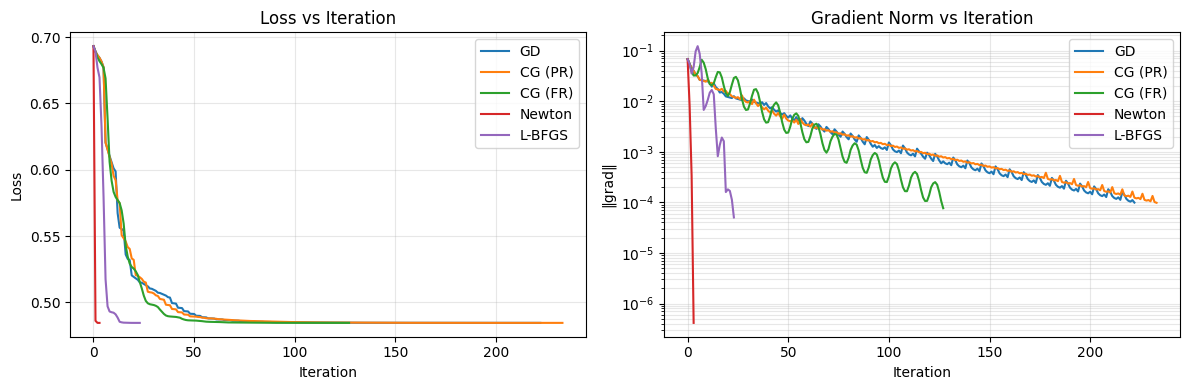

In [52]:
## plot convergence graphs

def plot_convergence(histories, labels):
    plt.figure(figsize=(12,4))

    # loss vs iteration
    plt.subplot(1, 2, 1)
    for H, lab in zip(histories, labels):
        plt.plot(H["loss"], label=lab)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Iteration")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # gradient norm vs iteration
    plt.subplot(1, 2, 2)
    for H, lab in zip(histories, labels):
        plt.semilogy(H["grad_norm"], label=lab)
    plt.xlabel("Iteration")
    plt.ylabel("‖grad‖")
    plt.title("Gradient Norm vs Iteration")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)

    plt.tight_layout()
    plt.show()

# save loss and grad norm histories during optimization
hist_gd = trial_points_gd  
hist_cg_pr = trial_points_cg_pr 
hist_cg_fr = trial_points_cg_fr    
hist_lbfgs = trial_points_qn
hist_newt = trial_points_n

plot_convergence(
    [hist_gd, hist_cg_pr, hist_cg_fr, hist_newt, hist_lbfgs],
    ["GD", "CG (PR)", "CG (FR)", "Newton", "L-BFGS"],
)


All methods show a rapid initial decrease in the loss (objective function), but the speed of convergence varies. Similarly, the gradient-norm plot highlights these differences in convergence rates more clearly:
- Newton method reaches its minimum almost immediately (within 3 iterations), showing its characteristic quadratic (or superlinear) convergence on smooth convex problems.

- L-BFGS also converges very quickly (within 23 iterations) and consistently (with slight oscillations), showing that it successfully captures curvature information without computing the full Hessian.

- CG (FR) converges faster than both GD and CG (PR), reaching the minimum in about half the iterations. It also shows an oscillating pattern in gradient norm, indicating less stable but consistent progress toward optimality.

- GD and CG (PR) follow almost identical gradual decay curves with lesser oscillations and require the most iterations (>220) before flattening out. This is consistent with linear convergence typical of steepest descent.

These reinforce the earlier observations about convergence speed, efficiency, and stability across the different optimization methods.

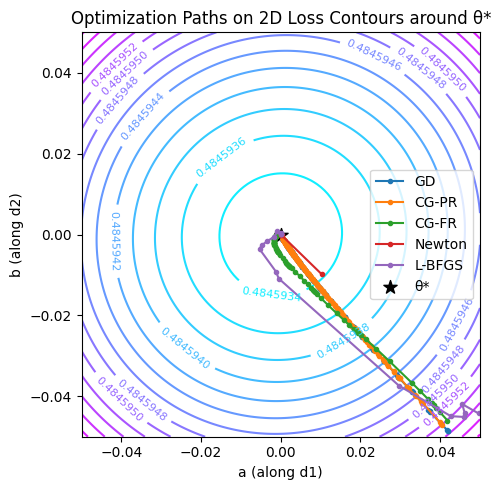

In [55]:
## plot 2D loss contour around optimal θ*
# since θ is high-dimensional, project onto a random 2D plane to see the optimization paths

theta_star = theta_n # use Newton method solution as θ*
d = theta_star.shape[0]
rng = np.random.default_rng(0)

# get random 2D orthonormal basis/plane (d1, d2) in R^d
D = rng.normal(size=(d, 2)) # matrix with 2 random directions
d1 = D[:, 0]; d1 /= np.linalg.norm(d1) # normalize first direction to unit vector
d2 = D[:, 1] - d1 * np.dot(d1, D[:, 1]) # make second direction orthogonal to first
d2 /= np.linalg.norm(d2) # normalize second direction

def compute_loss(a, b, theta_star, d1, d2, X, y): # get loss at point (a,b) on 2D plane
    theta = theta_star + a * d1 + b * d2 # move from θ* in directions (a,b)
    return lossfunc(theta, X, y) # get function value

def project_path(theta_path, theta_star, d1, d2):
    coords = []
    for th in theta_path:
        delta = th - theta_star # displacement from θ*
        a = np.dot(delta, d1) # get coordinates
        b = np.dot(delta, d2)
        coords.append((a, b))
    return np.array(coords)  # projected path

# get paths for each optimizer
path_gd = project_path(theta_path_gd, theta_star, d1, d2)
path_cg_pr = project_path(theta_path_cg_pr, theta_star, d1, d2)
path_cg_fr = project_path(theta_path_cg_fr, theta_star, d1, d2)
path_n = project_path(theta_path_n, theta_star, d1, d2)
path_qn = project_path(theta_path_qn, theta_star, d1, d2)

zoom_R = 0.05 # so zoomed in view
a_vals_z = np.linspace(-zoom_R, zoom_R, 121) # get grid
b_vals_z = np.linspace(-zoom_R, zoom_R, 121)
A_z, B_z = np.meshgrid(a_vals_z, b_vals_z)

Z_z = np.zeros_like(A_z) # compute loss values on grid
for i in range(A_z.shape[0]):
    for j in range(A_z.shape[1]):
        Z_z[i, j] = compute_loss(
            A_z[i, j], B_z[i, j],
            theta_star, d1, d2,
            X_train_tfidf, y_train.values
        )

plt.figure(figsize=(5,5))
cs = plt.contour(A_z, B_z, Z_z, levels=15, cmap="cool") # plot contours
plt.clabel(cs, inline=1, fontsize=8) # label contours

def plot_path(path2d, label):
    mask = (np.abs(path2d[:,0]) < zoom_R) & (np.abs(path2d[:,1]) < zoom_R) # only points inside grid
    plt.plot(path2d[mask,0], path2d[mask,1], '-o', markersize=3, label=label)

plot_path(path_gd, "GD")
plot_path(path_cg_pr, "CG-PR")
plot_path(path_cg_fr, "CG-FR")
plot_path(path_n, "Newton")
plot_path(path_qn, "L-BFGS")

plt.scatter(0.0, 0.0, c="black", marker="*", s=100, label="θ*")
plt.title("Optimization Paths on 2D Loss Contours around θ*")
plt.xlabel("a (along d1)")
plt.ylabel("b (along d2)")
plt.legend()
plt.tight_layout()
plt.show()


The contour plot shows the 2D slice of the loss function around the optimum $\theta^*$, projected onto a random 2D subspace spanned by two orthonormal directions. All methods move toward the same minimum with nearly similar trajectories, but their trajectories differ in smoothness and efficiency:

- Newton method moves almost directly to the optimum in a single step, reflecting its ability to use exact curvature to jump to the minimizer since it computes the exact Hessian. (Since only points that fall inside the zoom window are plotted, the trajectory appears to start within the innermost contour.)

- L-BFGS follows a short, smooth path to the optimum but does not jump as directly as Newton, showing that its approximate inverse Hessian captures curvature well.

- CG-FR and CG-PR follow very similar trajectories. They both take more intermediate steps than the faster methods, but still move efficiently along conjugate directions toward the optimum solution.

- Gradient Descent displays the longest path, which is a characteristic of steepest descent methods on curved contours. It takes many small steps as it moves along with the contour directions.

The contour plot visually confirms the numerical results.

## Discussion and Conclusion

The experiments were designed to answer two questions:
1. How do different optimization algorithms behave when applied to the same convex logistic-regression objective?
2. Which algorithm is most effective in terms of convergence speed, computational efficiency, and final accuracy?

All methods were initialized from the same starting point, and all converged to effectively the same solution, achieving exemplary and comparable performance (≈90% accuracy and ≈0.969 AUC). This is consistent with the convexity of the objective fucntion and shows that each method can reliably reach the global optimum.

First-order methods (Gradient Descent, Conjugate Gradient - Polak-Ribiere, Conjugate Gradient - Fletcher-Reeves) converge to the optimal solution but require many more iterations. Gradient Descent and CG-PR follow almost identical slow decay paths, whereas CG-FR converges more quickly and efficiently. This demonstrates that using the Fletcher–Reeves $\beta$ update formula and not employing truncation significantly improved its efficiency, likely because CG-PR experienced more resets due to truncation. Both CG methods followed an oscillatory pattern, which is expected due to alternating conjugate directions, reflecting less stable progress compared to curvature-based methods.

Second-order and quasi-Newton methods behave very differently. Newton’s method reaches the minimizer in only three iterations, reflecting its quadratic (superlinear) convergence, but the cost of forming and solving the Hessian and its inverse makes it the most expensive method computationally. Quasi-Newton (L-BFGS), on the other hand, converges in 23 iterations and is by far the fastest overall. While its gradient norm curve exhibits small oscillations—since it is a first-order method that approximates curvature, it makes fast, consistent progress efficiently without the cost of computing the full Hessian in every iteration.

Quantitatively, Newton has the fewest iterations (3), L-BFGS has the best runtime (1.3s), and all methods achieve the same final loss (0.48459). But overall, L-BFGS provides the best trade-off between speed and convergence, as it converges to nearly the same optimum Newton solution in 95% less time, is 5500× less expensive per iteration and uses ~500× less memory in theory for this problem. Hence, Quasi-Newton (L-BFGS) with approximate line search is the most efficient algorithm for this fake news detection problem.

One obstacle I ran into was interpreting optimization paths in a 5000-dimensional space. As with the class assignments, I was used to interpreting paths via contour plots. This was, however, difficult in such a high-dimensional space. To overcome this, I projected the optimization paths onto a random 2D subspace spanned by two orthonormal directions. This allowed me to visualize the trajectories of each method. However, I had to be cautious in interpreting these plots since they are only 2D slices of a much higher-dimensional space and may not capture the initial directions of movement, which could provide better or different insights.

Next time, or as an extension of the project, I would incorporate stochastic optimizers and other variants of Quasi-Newton methods to evaluate how they differ in convergence behavior on the sparse TF-IDF features. I would also explore more efficient ways to generate 2D trajectory plots. One possibility could be using Hessian eigenvectors. However, computing eigenvectors of a 5000×5000 Hessian is computationally expensive and would require careful consideration. I would also implement a more robust or customized line search beyond the SciPy implementation used in class.


### References

1. Nocedal, J. (1980). Updating Quasi-Newton Matrices with Limited Storage. Mathematics of Computation, 35(151), 773–782. https://doi.org/10.2307/2006193

2. Nocedal, J., & Wright, S. J. (2006). *Numerical Optimization* (2nd ed.). Springer. https://www.math.uci.edu/~qnie/Publications/NumericalOptimization.pdf

3. Shahane, S. (n.d.). Fake News Classification. Kaggle. Retrieved December 4, 2025, from https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

4. I used generative AI (ChatGPT) for help with the plotting code, especially for the 2D contour plot.